In [1]:
%load_ext autoreload
%autoreload 2  
%reload_ext autoreload

In [2]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tskit as tsk
from bgspy.recmap import RecMap
from bgspy.utils import load_seqlens

# Validation and Cleanup of the Hinch et al. Recombination Map

The source of the hg36 recombination map is [here](https://www.well.ox.ac.uk/~anjali/AAmap/). See the `Snakefile` for the processing of this. This is just to ensure the processing/liftover/scaling etc is correct. We need to remove some outliers.

In [3]:
hg38sl = load_seqlens('../data/annotation/hg38_seqlens.tsv')
chroms = list(hg38sl.keys())

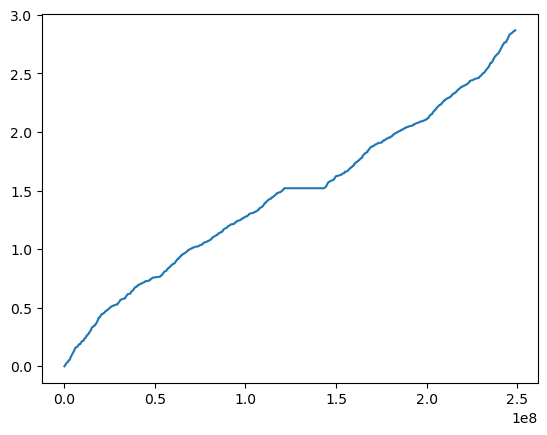

In [4]:
hm = RecMap('../data/annotation/hapmap_genetic_map.txt', 
            seqlens=hg38sl)

hmcr = hm.cum_rates['chr1']
plt.plot(hmcr.end, hmcr.rate)

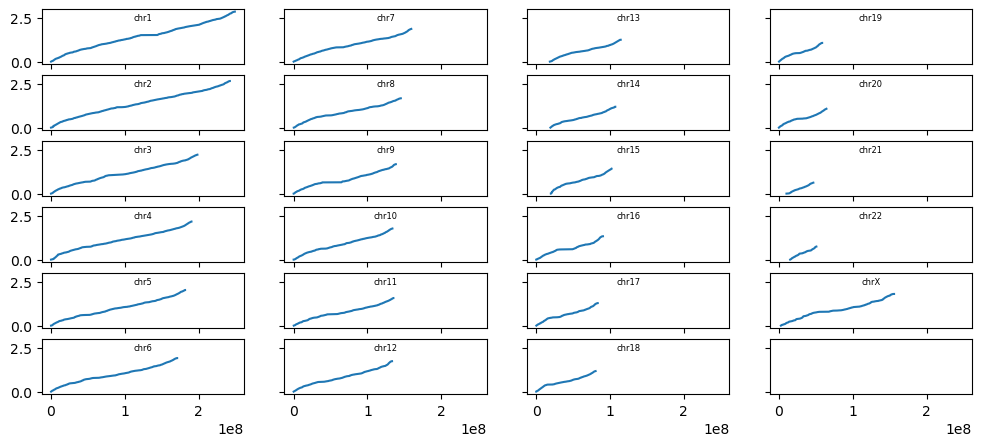

In [5]:
nc, nr = 4, 6

fig, ax = plt.subplots(ncols=nc, nrows=nr, figsize=(12, 5), sharex=True, sharey=True)
entries = list(itertools.product(list(range(nc)), list(range(nr))))
for i, chrom in enumerate(chroms):
    row, col = entries[i]
    fax = ax[col, row]    
    hmcr = hm.cum_rates[chrom]
    fax.plot(hmcr.end, hmcr.rate)
    fax.text(0.5, 0.8, chrom, fontsize=6, 
             horizontalalignment='center',
             transform=fax.transAxes)

In [6]:
d = pd.read_table('../data/annotation/aamap_hg38_raw.bed', sep='\t',
                  names=('chrom', 'start', 'end', 'rate'))
d.head()

,chrom,start,end,rate
0,chr1,817341,818802,6.134879e-12
1,chr1,818802,825532,4.800280e-12
2,chr1,825532,833068,5.329727e-12
3,chr1,833068,841166,6.317943e-12
4,chr1,841166,843942,4.908610e-12


## Filtering on Rates

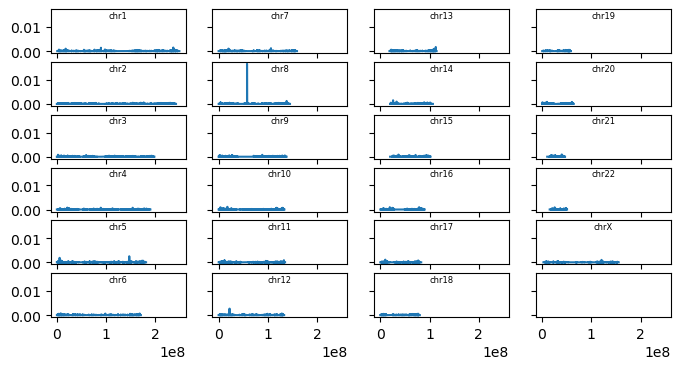

In [7]:
nc, nr = 4, 6

fig, ax = plt.subplots(ncols=nc, nrows=nr, figsize=(8, 4), sharex=True, sharey=True)
entries = list(itertools.product(list(range(nc)), list(range(nr))))
for i, chrom in enumerate(chroms):
    row, col = entries[i]
    dc = d.loc[d['chrom'] == chrom]
    #dc = dc[dc['rate'] < 0.002]
    fax = ax[col, row]
    fax.plot(0.5*(dc['start']+dc['end']), dc['rate'], label='raw Hinch et al. hg36')
    fax.text(0.5, 0.8, chrom, fontsize=6, 
             horizontalalignment='center',
             transform=fax.transAxes)

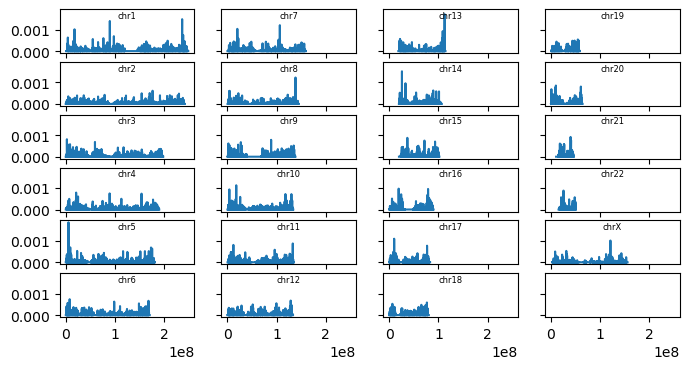

In [8]:
THRESH = 0.002
nc, nr = 4, 6

fig, ax = plt.subplots(ncols=nc, nrows=nr, figsize=(8, 4), sharex=True, sharey=True)
entries = list(itertools.product(list(range(nc)), list(range(nr))))
for i, chrom in enumerate(chroms):
    row, col = entries[i]
    dc = d.loc[d['chrom'] == chrom]
    dc = dc[dc['rate'] < THRESH]
    fax = ax[col, row]
    fax.plot(0.5*(dc['start']+dc['end']), dc['rate'], label='raw Hinch et al. hg36')
    fax.text(0.5, 0.8, chrom, fontsize=6, 
             horizontalalignment='center',
             transform=fax.transAxes)

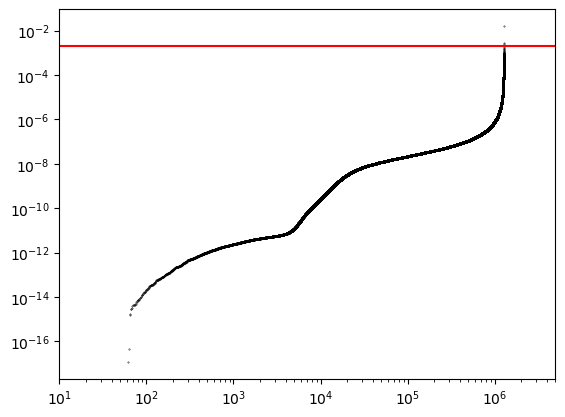

In [9]:
x = np.sort(d['rate'])
plt.scatter(np.arange(len(x)), x, s=0.1, c='k')
plt.loglog()
plt.xlim(10, 5e6)
plt.axhline(THRESH, c='r')

/tmp/ipykernel_23740/2361572667.py:5: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(1e-8, 0)


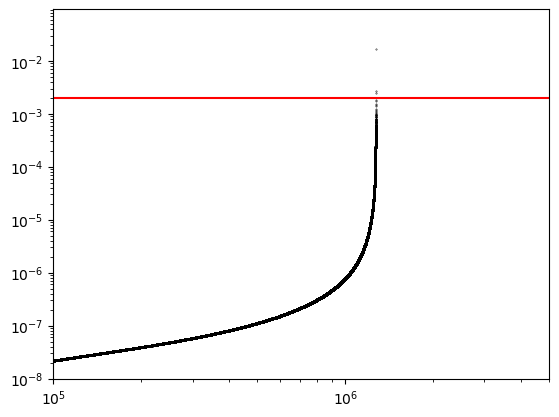

In [10]:
x = np.sort(d['rate'])
plt.scatter(np.arange(len(x)), x, s=0.1, c='k')
plt.loglog()
plt.xlim(1e5, 5e6)
plt.ylim(1e-8, 0)
plt.axhline(THRESH, c='r')

In [11]:
chroms = [f"chr{f}" for f in range(1, 23)]
def read(c):
    return pd.read_table(f"../data/annotation/AAmap/AAmap.{c}.txt", 
                         skiprows=1, sep=' ', 
                         names=('pos', 'rate'))

# hg36 hinch (no liftover)
raw_hinsh = {c: read(c) for c in chroms}

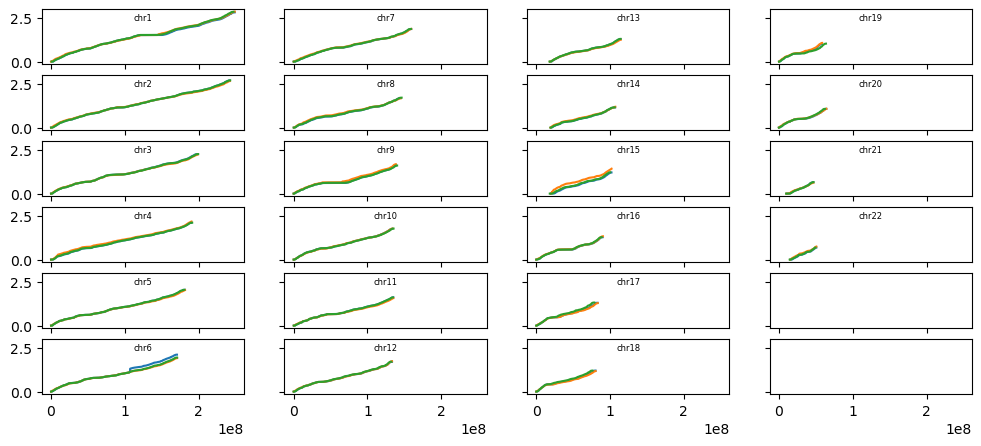

In [12]:
THRESH = 0.002
nc, nr = 4, 6

fig, ax = plt.subplots(ncols=nc, nrows=nr, figsize=(12, 5), sharex=True, sharey=True)
entries = list(itertools.product(list(range(nc)), list(range(nr))))
for i, chrom in enumerate(chroms):
    row, col = entries[i]
    dc = d.loc[d['chrom'] == chrom]
    dc = dc[dc['rate'] < THRESH]
    dc = dc.sort_values(['start', 'end'])
    fax = ax[col, row]    
    fax.plot(dc['end'], 1/100 * np.cumsum(dc['rate'] * (dc['end']-dc['start'])), label='liftover Hinch hg38')
    
    hmcr = hm.cum_rates[chrom]
    fax.plot(hmcr.end, hmcr.rate)
    
    dh = raw_hinsh[chrom]
    x, y = dh['pos'], dh['rate']
    fax.plot(x, y/100)
    fax.text(0.5, 0.8, chrom, fontsize=6, 
             horizontalalignment='center',
             transform=fax.transAxes)

## The chromosome 6 outlier

You can see chr6 has one more issue we need to clean up

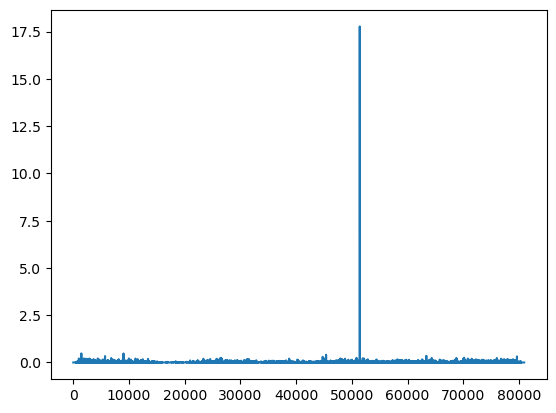

In [13]:
dc = d.loc[d['chrom'] == 'chr6']
dc = dc.sort_values(['start', 'end'])
dc['dist'] = dc['rate'] * (dc['end']-dc['start'])
dc['cumm'] = np.cumsum(dc['dist'])

ydiff = dc['cumm'].diff().values
plt.plot(ydiff)

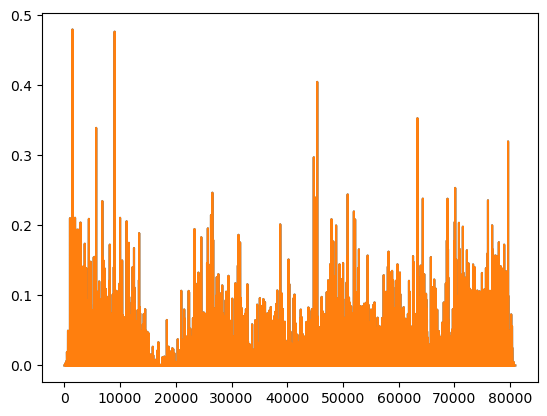

In [14]:
dc = d.loc[d['chrom'] == 'chr6']
dc = dc.sort_values(['start', 'end'])
dc['dist'] = dc['rate'] * (dc['end']-dc['start'])
# the filter has to go here
dc = dc.loc[dc['dist'] < 2.5]
dc['cumm'] = np.cumsum(dc['dist'])

ydiff = dc['cumm'].diff().values
plt.plot(ydiff)
plt.plot(ydiff[ydiff < 2.5])

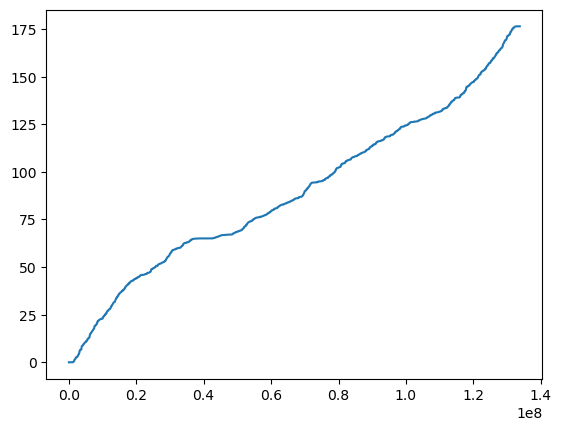

In [24]:
dc = d.loc[d['chrom'] == 'chr10']
dc = dc.sort_values(['start', 'end'])
dc['dist'] = dc['rate'] * (dc['end']-dc['start'])
dc['cumm'] = np.cumsum(dc['dist'])


plt.plot(dc['end'], dc['cumm'])

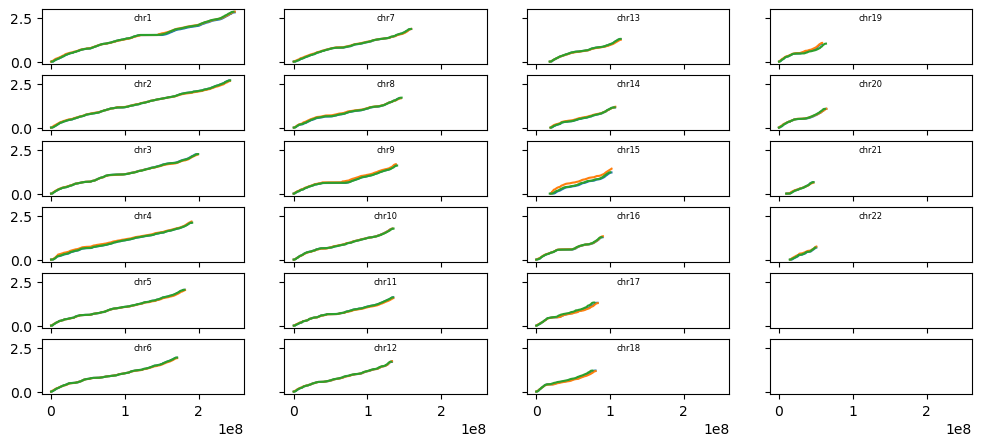

In [15]:
nc, nr = 4, 6

fig, ax = plt.subplots(ncols=nc, nrows=nr, figsize=(12, 5), sharex=True, sharey=True)
entries = list(itertools.product(list(range(nc)), list(range(nr))))
for i, chrom in enumerate(chroms):
    row, col = entries[i]
    dc = d.loc[d['chrom'] == chrom]
    dc = dc[dc['rate'] < THRESH]
    dc = dc.sort_values(['end'])
    
    if chrom == 'chr6':
        # filter out the chr6 outlier
        dc = dc.loc[dc['rate'] * (dc['end']-dc['start']) < 2.5]
    
    #assert np.all(dc['end'].diff() > 0), chrom
    fax = ax[col, row]    
    fax.plot(dc['end'], 1/100 * np.cumsum(dc['rate'] * (dc['end']-dc['start'])), label='Hinch hg38 filtered')
    
    hmcr = hm.cum_rates[chrom]
    fax.plot(hmcr.end, hmcr.rate, label='hapmap')
    
    if chrom in raw_hinsh:
        dh = raw_hinsh[chrom]
        x, y = dh['pos'], dh['rate']
        fax.plot(x, y/100, label='Hinch hg36')
    fax.text(0.5, 0.8, chrom, fontsize=6, 
             horizontalalignment='center',
             transform=fax.transAxes)

In [87]:
rr

array([1.34747837e-09, 3.23232301e-10, 2.43789576e-10, ...,
       1.44999568e-11, 1.44858991e-09, 5.10961007e-09])

In [102]:
new_ends.shape, new_rates.shape

((65169,), (65167,))

In [108]:
new_ends.shape, new_rates.shape

((65170,), (65168,))

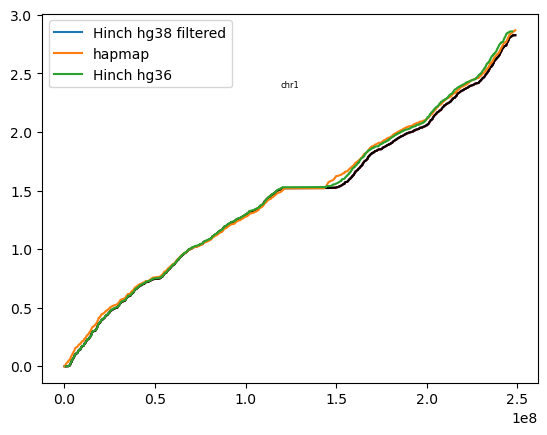

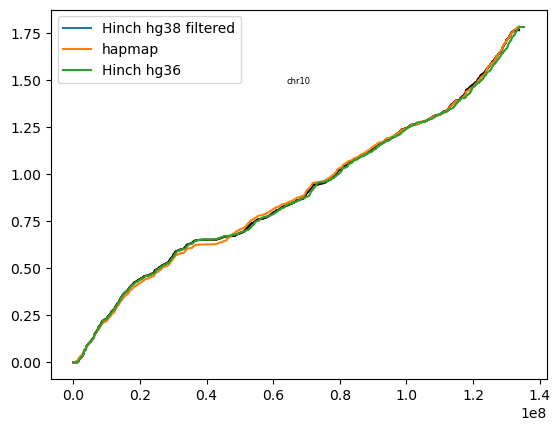

In [118]:
for i, chrom in enumerate(['chr1', 'chr10']):
    fig, fax = plt.subplots()

    dc = d.loc[d['chrom'] == chrom]
    dc = dc[dc['rate'] < THRESH]
    dc = dc.sort_values(['end'])
    
    if chrom == 'chr6':
        # filter out the chr6 outlier
        dc = dc.loc[dc['rate'] * (dc['end']-dc['start']) < 2.5]
    
    # the filtered set
    fax.plot(dc['end'], 1/100 * np.cumsum(dc['rate'] * (dc['end']-dc['start'])), label='Hinch hg38 filtered')
    
    # now, we try to reconstruct the filtered set, from cumulative to rates
    # then make a cumulative map from this, and plot to compare —— should match
    # if we're doing this right
    ends = dc['end'].values
    starts = dc['start'].values
    span = ends - starts
    y = 1/100 * np.cumsum(dc['rate'] * span)
    rr = np.diff(y)
    plt.plot(ends[:-1], np.cumsum(rr), c='r')
    
    # now, we do another check, that if we put in the rates 
    # in a RateMap, that the cumulative mass from that also lines up
    new_rates = list(rr)
    new_ends = list(ends[:-1])
    new_ends.insert(0, 0)
    new_rates.insert(0, np.nan)
    new_ends.append(hg38sl[chrom])
    new_ends, new_rates = np.array(new_ends), np.array(new_rates) / np.diff(new_ends)
    tr = tsk.RateMap(position=new_ends, rate=new_rates)
    fax.plot(tr.position, tr.get_cumulative_mass(tr.position), c='k')
    
    # the hapmap set
    hmcr = hm.cum_rates[chrom]
    fax.plot(hmcr.end, hmcr.rate, label="hapmap")
    
    # raw hinch
    if chrom in raw_hinsh:
        dh = raw_hinsh[chrom]
        x, y = dh['pos'], dh['rate']
        fax.plot(x, y/100, label="Hinch hg36")
    fax.legend()
    fax.text(0.5, 0.8, chrom, fontsize=6, 
             horizontalalignment='center',
             transform=fax.transAxes)

## Summary

 - Special filtering of chr6
 - General outlier filtering
 
 The following code is used in the snakemake pipeline.

## Validation

### Check all in Order

In [17]:
fixed = []
rms = dict()
for chrom in chroms:
    dc = d.loc[d['chrom'] == chrom]
    dc = dc[dc['rate'] < THRESH]
    dc = dc.sort_values(['end'])
    
    if chrom == 'chr6':
        # filter out the chr6 outlier
        dc = dc.loc[dc['rate'] * (dc['end']-dc['start']) < 2.5]
    
    dc = d.loc[d['chrom'] == chrom]
    
    # build rate map
    rms[chrom] = tsk.RateMap(position=[0] + dc['end'].tolist(), rate=dc['rate'])
    fixed.append(dc)
    print(chrom, (dc['end'].diff() <= 0).sum())

chr1 0
chr2 0
chr3 0
chr4 0
chr5 0
chr6 0
chr7 0
chr8 0
chr9 0
chr10 0
chr11 0
chr12 0
chr13 0
chr14 0
chr15 0
chr16 0
chr17 0
chr18 0
chr19 0
chr20 0
chr21 0
chr22 0


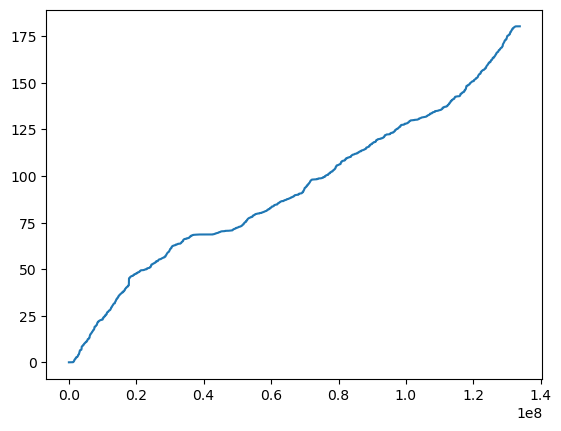

In [38]:
rr = rms['chr10']
plt.plot(rr.right, rr.get_cumulative_mass(rr.right))

### Snakemake Output and RecMap Object Validation

Now, let's analyze the results **as they come out of snakemake**.

In [126]:
rm = RecMap('../data/annotation/aamap_hg38.tsv', 
            seqlens=hg38sl, conversion_factor=1)

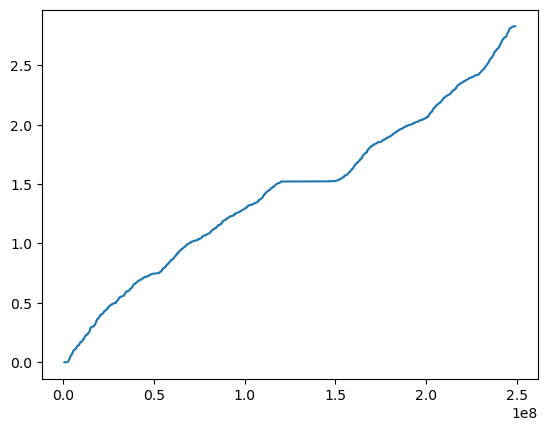

In [127]:
plt.plot(*rm.cum_rates['chr1'])

### All Validation Plots

/tmp/ipykernel_23740/2852473505.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, fax = plt.subplots(figsize=(12, 5), sharex=True, sharey=True)


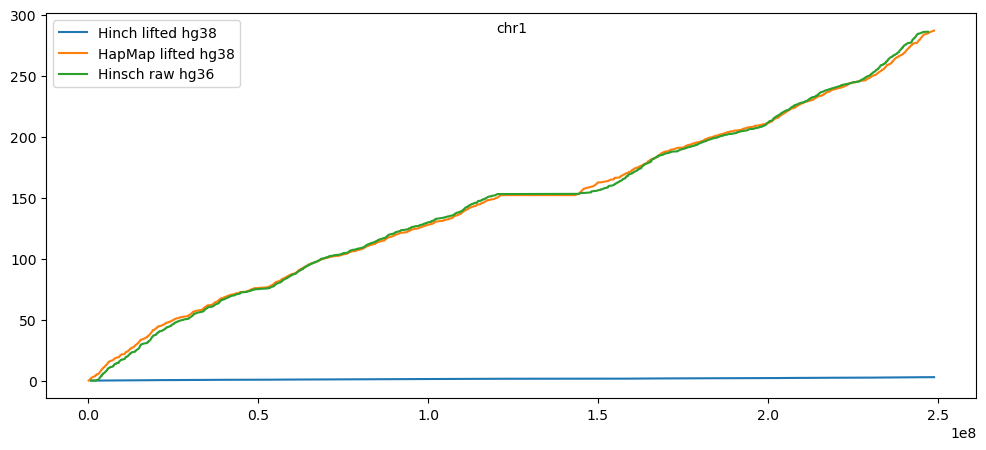

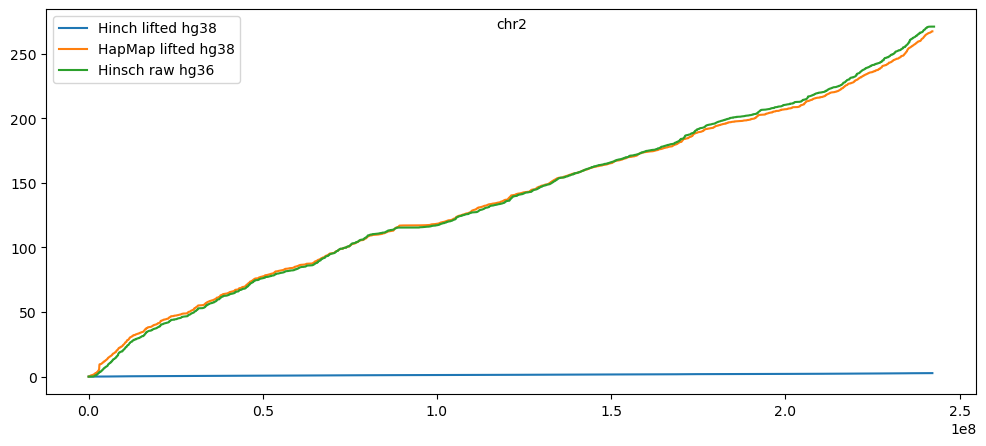

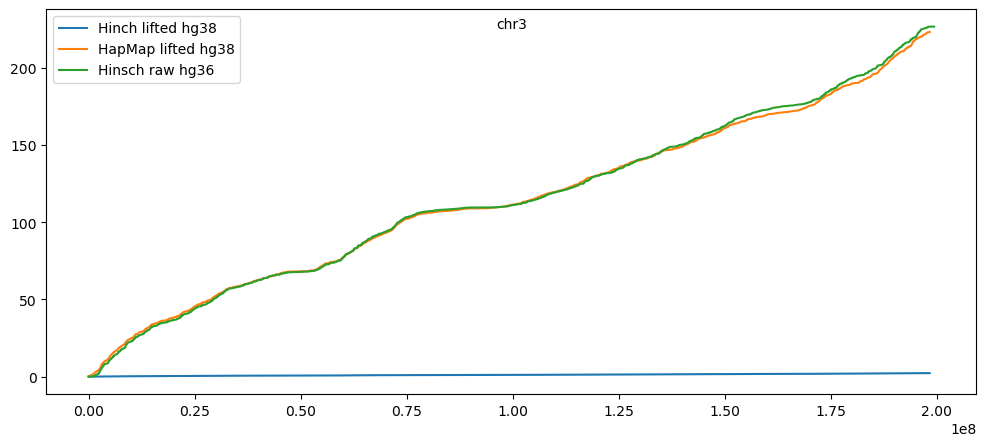

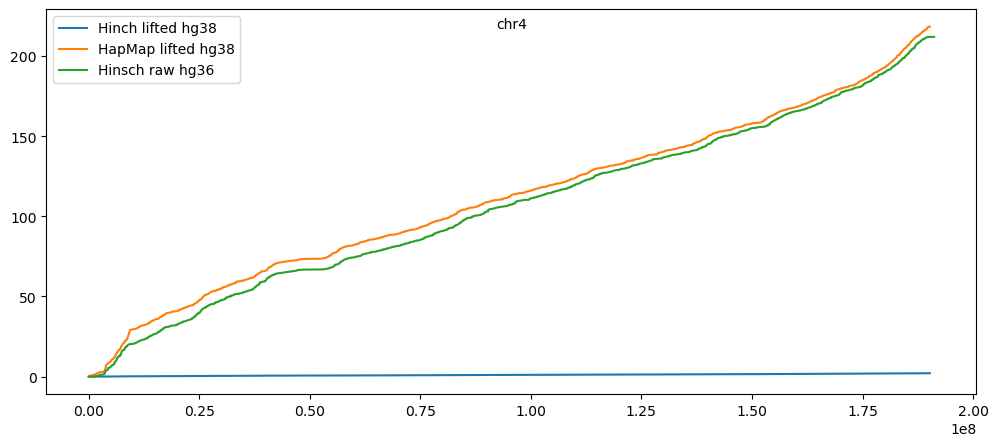

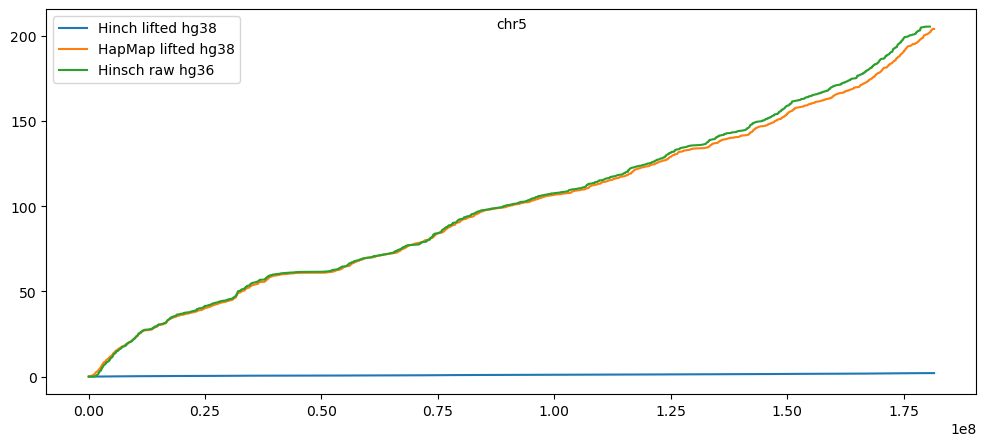

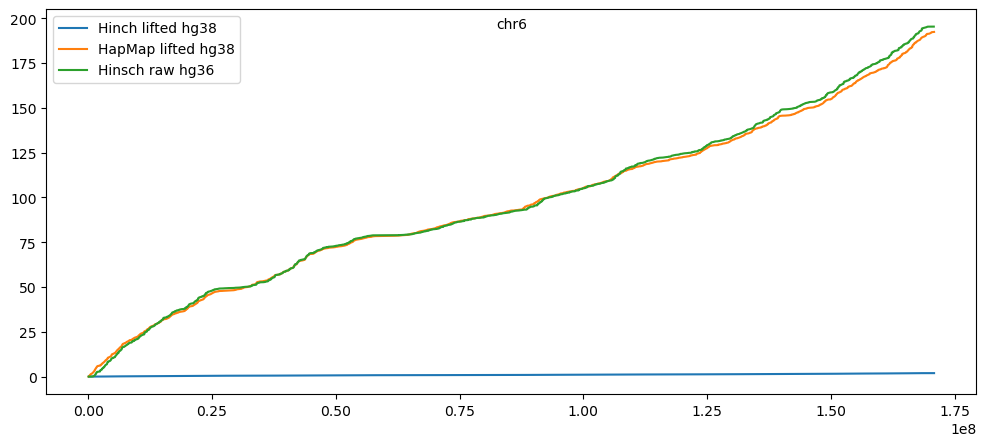

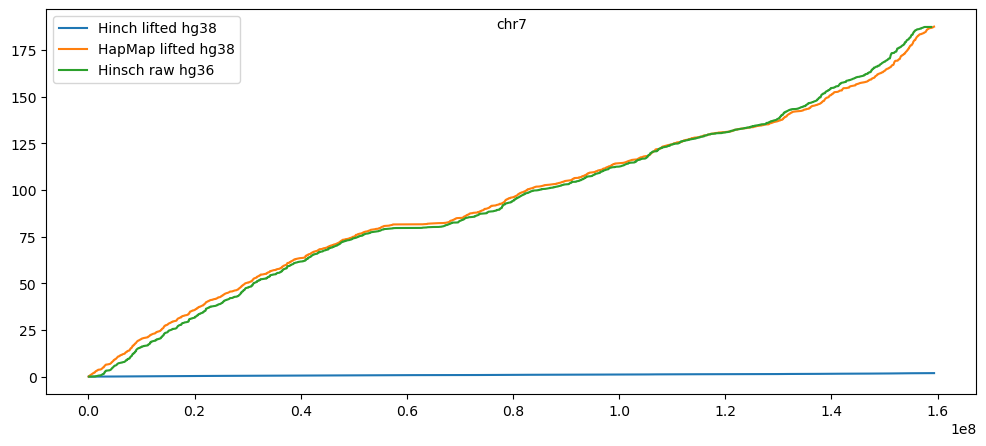

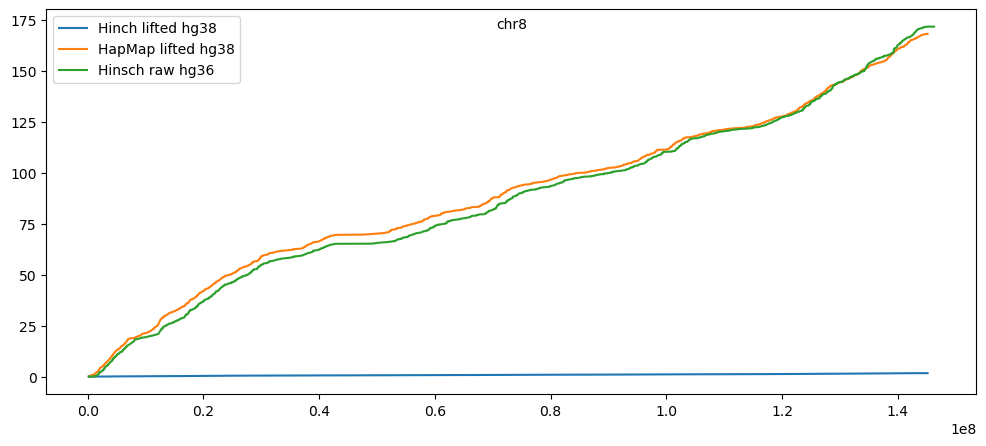

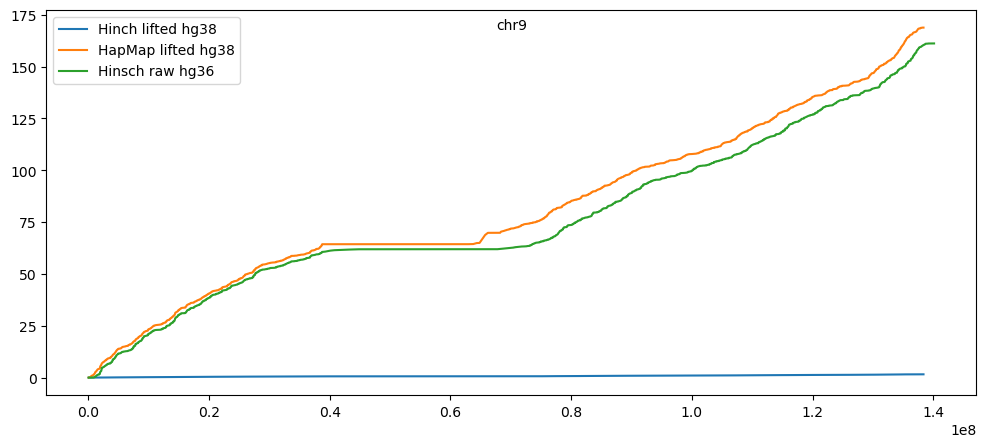

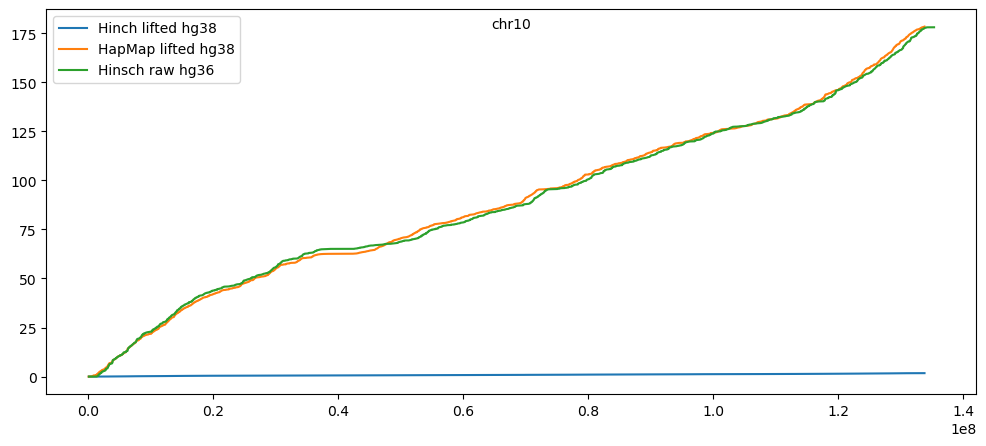

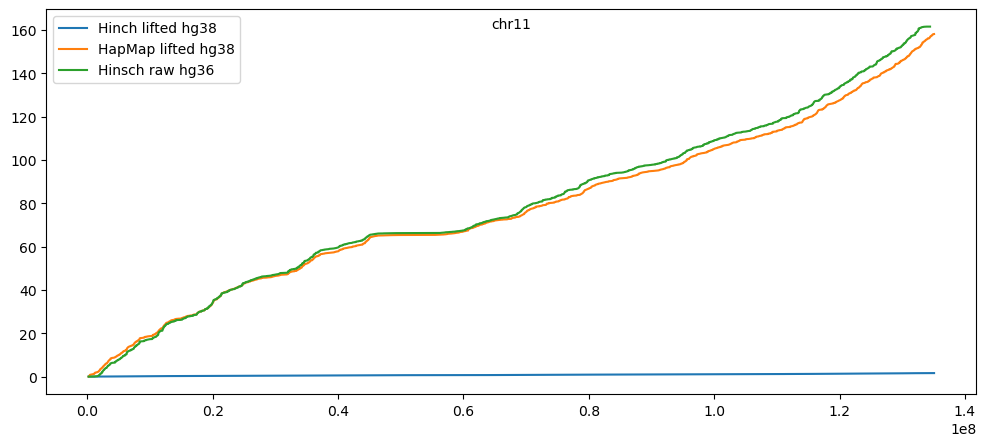

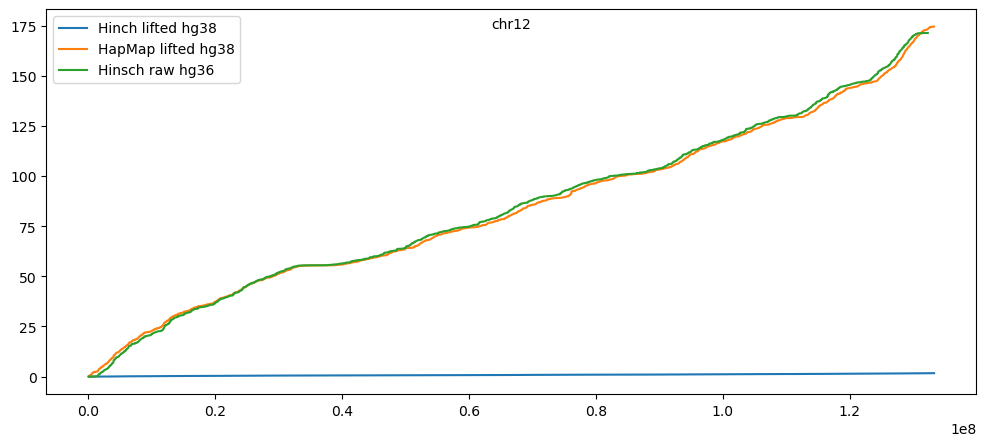

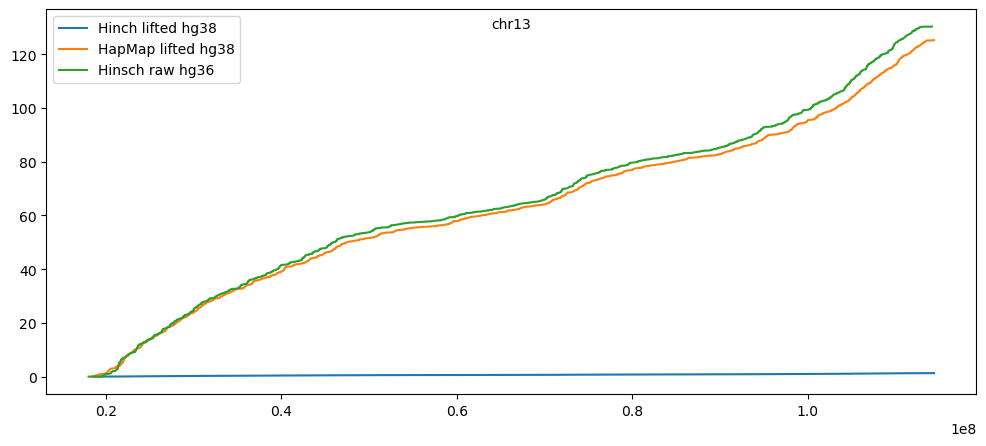

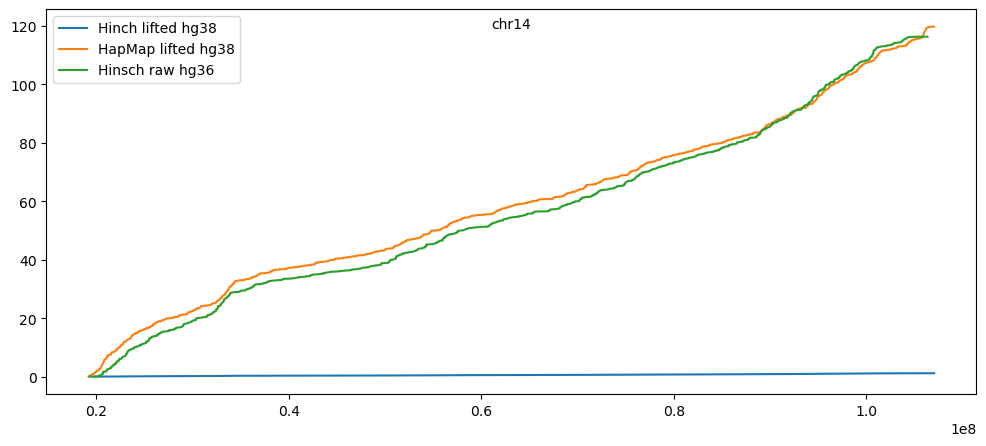

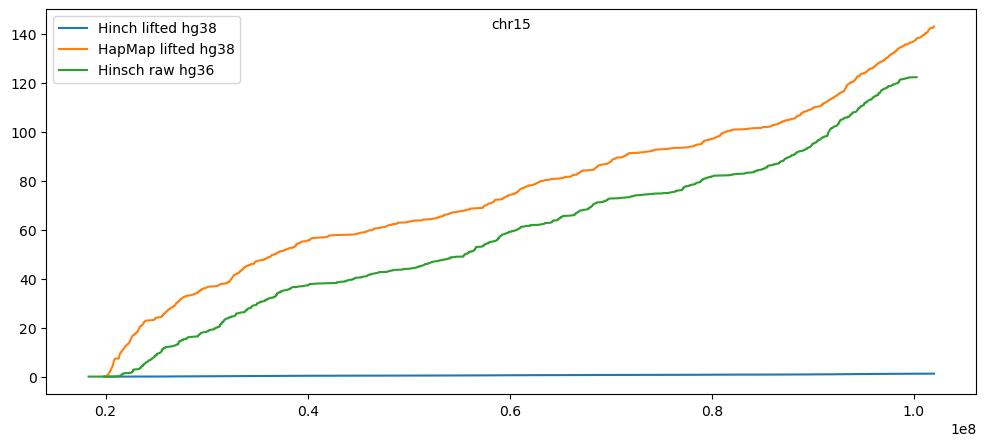

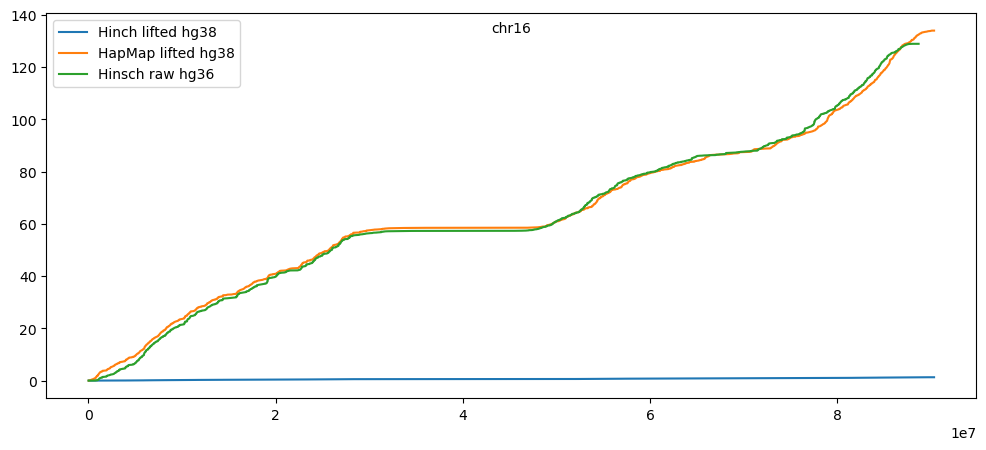

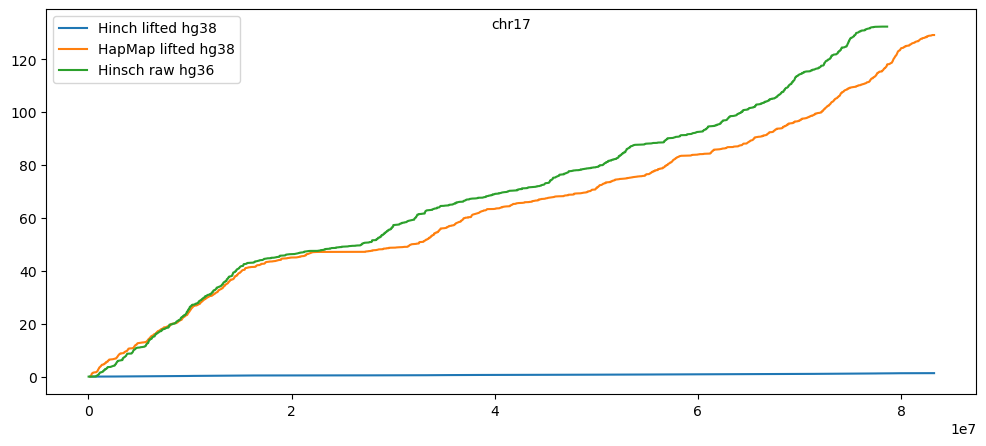

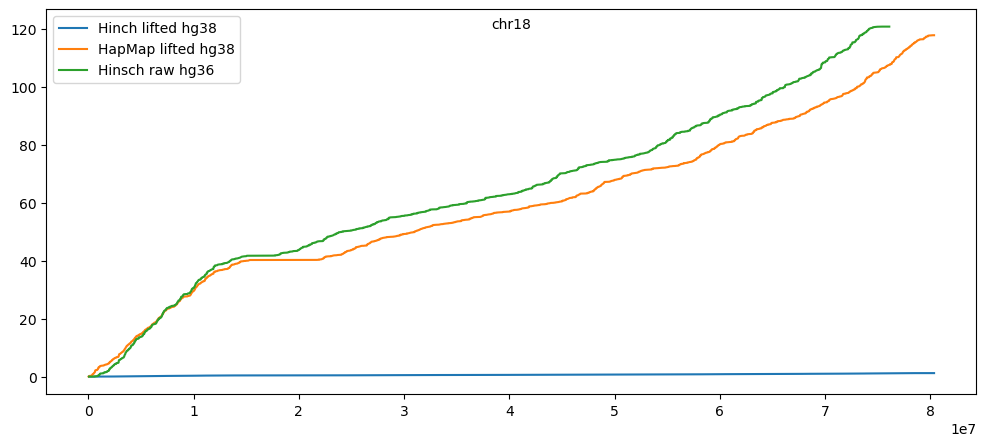

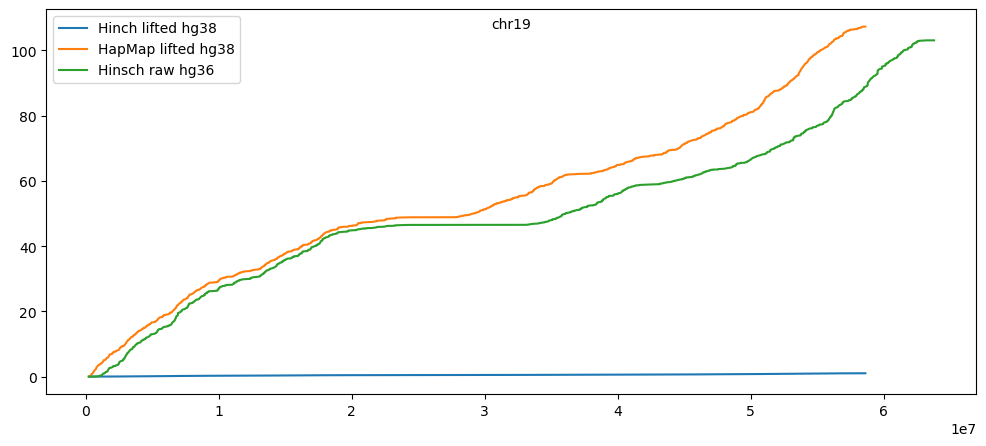

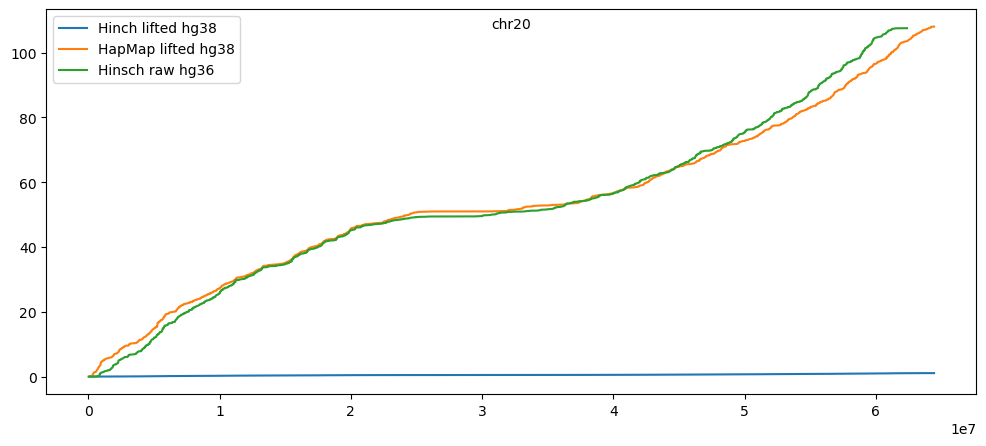

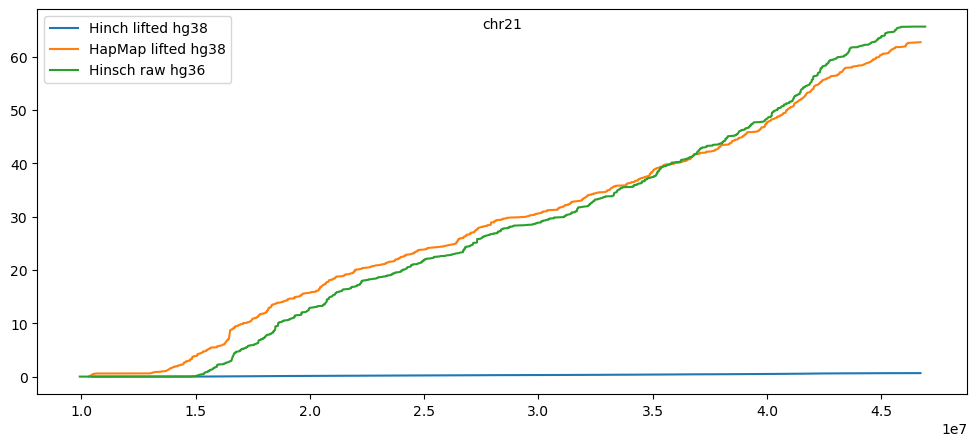

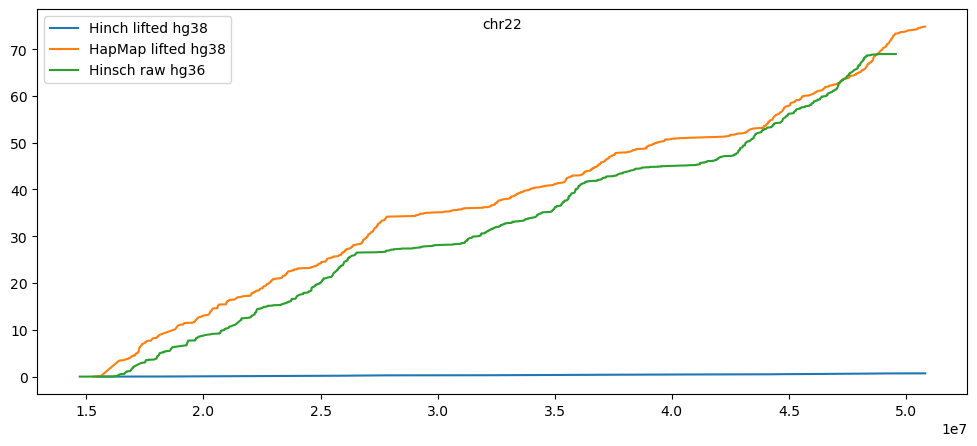

In [128]:
for i, chrom in enumerate(chroms):
    fig, fax = plt.subplots(figsize=(12, 5), sharex=True, sharey=True)
    row, col = entries[i]
    #dc = dfixed.loc[dfixed['chrom'] == chrom]
    
    #fax.plot(dc['end'], dc['cum'], label='fixed Hinch et al. hg38')
    x, y = rm.cum_rates[chrom]
    fax.plot(x, y, label='Hinch lifted hg38')
    
    x, y = hm.cum_rates[chrom]
    fax.plot(x, 100*y, label='HapMap lifted hg38')
    
    if chrom in raw_hinsh:
        dh = raw_hinsh[chrom]
        x, y = dh['pos'], dh['rate']
        fax.plot(x, y, label='Hinsch raw hg36')
    
    fax.text(0.5, 0.95, chrom, fontsize=10, 
             horizontalalignment='center',
             transform=fax.transAxes)
    fax.legend()